In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '20 days LSTM Time Series Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [8]:
nr_test_sets = ['600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-13   589.000000  582.108121 -38.732394  1.228418e+09     2.0
2018-12-14   601.750000  585.129949 -20.774648  1.232458e+09     2.0
2018-12-17   592.960022  586.334575 -33.154899  1.230002e+09     2.0
2018-12-18   590.520020  586.978490 -36.591522  1.227513e+09     2.0
2018-12-19   590.940002  587.587953 -37.872279  1.229435e+09     2.0


In [9]:
r_test_sets = ['600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2019-12-16  1163.000000  1157.540407 -41.535401  54780462.0     2.0
2019-12-17  1147.920044  1156.060351 -58.603130  51686820.0     2.0
2019-12-18  1169.979980  1158.201833 -32.533716  55948516.0     2.0
2019-12-19  1168.000000  1159.709243 -12.676282  53984507.0     2.0
2019-12-20  1157.400024  1159.353979 -31.925802  52029277.0     2.0


### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


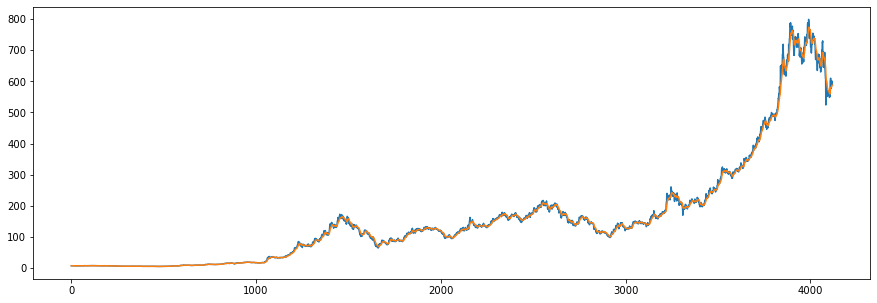

In [10]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 3733, 1.0: 183, 0.0: 185})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('600519.SS')]
    y = nr_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('600519.SS'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('600519.SS')]
    y = r_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.387387387387387, 1: 7.488584474885845, 2: 0.3661531591873186}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 1s 37ms/step - loss: 0.2990 - accuracy: 0.5814 - mse: 0.4133 - weighted_accuracy: 0.3253 - weighted_mse: 0.5155 - val_loss: 0.3005 - val_accuracy: 0.0487 - val_mse: 0.3519 - val_weighted_accuracy: 0.0487 - val_weighted_mse: 0.3519
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2183 - accuracy: 0.4909 - mse: 0.6706 - weighted_accuracy: 0.4366 - weighted_mse: 0.7088 - val_loss: 0.2934 - val_accuracy: 0.0451 - val_mse: 0.3778 - val_weighted_accuracy: 0.0451 - val_weighted_mse: 0.3778
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1953 - accuracy: 0.3518 - mse: 0.9120 - weighted_accuracy: 0.4827 - weighted_mse: 0.9042 - val_loss: 0.2849 - val_accuracy: 0.0451 - val_mse: 0.4146 - val_weighted_accuracy: 0.0451 - val_weighted_mse: 0.4146
Epoch 4/20
26/26 [==============================] - 0s 9m

7/7 [==============================] - 0s 3ms/step - loss: 0.1783 - accuracy: 0.4327 - mse: 1.1464 - weighted_accuracy: 0.4327 - weighted_mse: 1.1464


<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1782994270324707
Test accuracy: 0.4326923191547394


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 5
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 77
actual holds but predicted sell: 28
actual predicted holds: 84
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 91.30434782608695%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 40.69767441860465%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 86.81318681318682%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 15.717304419064138%
Share price: $0.14572012793439182
Shares owned at the moment: 0
Cash capital at the moment: $11

26/26 [==============================] - 0s 8ms/step - loss: 0.1263 - accuracy: 0.4814 - mse: 1.7246 - weighted_accuracy: 0.7477 - weighted_mse: 1.6665 - val_loss: 0.1840 - val_accuracy: 0.4348 - val_mse: 1.7447 - val_weighted_accuracy: 0.4348 - val_weighted_mse: 1.7447
Epoch 19/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1249 - accuracy: 0.4963 - mse: 1.7528 - weighted_accuracy: 0.7554 - weighted_mse: 1.7097 - val_loss: 0.1919 - val_accuracy: 0.4080 - val_mse: 1.8291 - val_weighted_accuracy: 0.4080 - val_weighted_mse: 1.8291
Epoch 20/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1240 - accuracy: 0.4881 - mse: 1.7862 - weighted_accuracy: 0.7652 - weighted_mse: 1.7336 - val_loss: 0.1847 - val_accuracy: 0.4543 - val_mse: 1.8332 - val_weighted_accuracy: 0.4543 - val_weighted_mse: 1.8332
Validation loss: 0.18471764028072357
Validation accuracy: 0.45432400703430176


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1231 - accuracy: 0.5204 - mse: 1.7919 - weighted_accuracy: 0.7642 - weighted_mse: 1.7467 - val_loss: 0.2057 - val_accuracy: 0.3752 - val_mse: 1.8524 - val_weighted_accuracy: 0.3752 - val_weighted_mse: 1.8524
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1223 - accuracy: 0.5259 - mse: 1.8088 - weighted_accuracy: 0.7770 - weighted_mse: 1.7661 - val_loss: 0.2065 - val_accuracy: 0.3557 - val_mse: 1.9636 - val_weighted_accuracy: 0.3557 - val_weighted_mse: 1.9636
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1208 - accuracy: 0.4832 - mse: 1.8495 - weighted_accuracy: 0.7807 - weighted_mse: 1.7962 - val_loss: 0.1734 - val_accuracy: 0.5164 - val_mse: 1.8883 - val_weighted_accuracy: 0.5164 - val_weighted_mse: 1.8883
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1201 - accuracy: 0.5256 - mse: 1.8317 - weighted_accuracy: 0.7790 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.5673 - mse: 2.1670 - weighted_accuracy: 0.5673 - weighted_mse: 2.1670
Test loss: 0.1572602540254593
Test accuracy: 0.567307710647583


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 30
actual holds but predicted sell: 48
actual predicted holds: 111
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 90.98360655737704%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 54.90196078431372%
Percentage mid holds correct: 84.42622950819673%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pric

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.6305 - mse: 2.1671 - weighted_accuracy: 0.8389 - weighted_mse: 2.1923 - val_loss: 0.1911 - val_accuracy: 0.5079 - val_mse: 2.2711 - val_weighted_accuracy: 0.5079 - val_weighted_mse: 2.2711
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1025 - accuracy: 0.6317 - mse: 2.1908 - weighted_accuracy: 0.8394 - weighted_mse: 2.2133 - val_loss: 0.1877 - val_accuracy: 0.5018 - val_mse: 2.4357 - val_weighted_accuracy: 0.5018 - val_weighted_mse: 2.4357
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1017 - accuracy: 0.6152 - mse: 2.2204 - weighted_accuracy: 0.8462 - weighted_mse: 2.2441 - val_loss: 0.1601 - val_accuracy: 0.6017 - val_mse: 2.3478 - val_weighted_accuracy: 0.6017 - val_weighted_mse: 2.3478
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.1014 - accuracy: 0.6415 - mse: 2.2232 - weighted_accuracy: 0.8408 - weighted_mse: 2.2524 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1353 - accuracy: 0.6683 - mse: 2.7647 - weighted_accuracy: 0.6683 - weighted_mse: 2.7647
Test loss: 0.13534270226955414
Test accuracy: 0.6682692170143127




<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 21
actual holds but predicted sell: 35
actual predicted holds: 133
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 12.195121951219512%
Percentage holds correct: 92.36111111111111%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 47.82608695652174%
Percentage high sells correct: 58.53658536585366%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 29.33434769325627%
Share price: $0.16286775592283398
Shares owned at the moment: 0
Cash capital at the moment: $128.9747909069938


Share price: $0.09165518418716977
Shares owned 

Epoch 19/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0703 - accuracy: 0.7823 - mse: 3.3452 - weighted_accuracy: 0.9095 - weighted_mse: 3.4610 - val_loss: 0.1705 - val_accuracy: 0.6456 - val_mse: 3.6116 - val_weighted_accuracy: 0.6456 - val_weighted_mse: 3.6116
Epoch 20/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.7683 - mse: 3.3764 - weighted_accuracy: 0.9044 - weighted_mse: 3.4882 - val_loss: 0.1659 - val_accuracy: 0.6906 - val_mse: 3.6950 - val_weighted_accuracy: 0.6906 - val_weighted_mse: 3.6950
Validation loss: 0.16586364805698395
Validation accuracy: 0.6906211972236633


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.6715 - mse: 4.0687 - weighted_accuracy: 0.6715 - weighted_mse: 4.0687
Test loss: 0.15473946928977966
Test accuracy: 0.6714975833892822


number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold:

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 10
actual holds but predicted sell: 16
actual predicted holds: 163
Percentage buys correct: 0.0%
Percentage sells correct: 22.727272727272727%
Percentage holds correct: 93.14285714285714%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 59.09090909090909%
Percentage mid holds correct: 86.7816091954023%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 14.685293009575151%
Share price: $0.14442053980990632
Shares owned at the moment: 0
Cash capital at the moment: $114.36798080971178


Share price: $0.11486371943609373
Shares owned at the moment:

7/7 [==============================] - 0s 3ms/step - loss: 0.1605 - accuracy: 0.7391 - mse: 5.1704 - weighted_accuracy: 0.7391 - weighted_mse: 5.1704
Test loss: 0.16053883731365204
Test accuracy: 0.739130437374115


number of predictions: 207
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 26
actual predicted holds: 147
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 90.74074074074075%
actual buys: 11
actual sells: 11
actual holds: 185


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 65.51724137931035%
Percentage mid holds correct: 87.03703703703704%


Capital: 100
Share price: $0.27983446457369765
Shares owned at the moment: 356
Cash capital at the moment: $0.10497267094598328


Price increase from previousl

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 8ms/step - loss: 0.0587 - accuracy: 0.8284 - mse: 4.4083 - weighted_accuracy: 0.9328 - weighted_mse: 4.5029 - val_loss: 0.1777 - val_accuracy: 0.6845 - val_mse: 4.8207 - val_weighted_accuracy: 0.6845 - val_weighted_mse: 4.8207
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0558 - accuracy: 0.8338 - mse: 4.4929 - weighted_accuracy: 0.9349 - weighted_mse: 4.5263 - val_loss: 0.1780 - val_accuracy: 0.6760 - val_mse: 4.8534 - val_weighted_accuracy: 0.6760 - val_weighted_mse: 4.8534
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.8348 - mse: 4.5134 - weighted_accuracy: 0.9374 - weighted_mse: 4.5916 - val_loss: 0.1566 - val_accuracy: 0.7503 - val_mse: 5.0568 - val_weighted_accuracy: 0.7503 - val_weighted_mse: 5.0568
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.8314 - mse: 4.6346 - weighted_accuracy: 0.9318 - weighted_mse: 4.6512 - 

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 7
actual holds but predicted sell: 11
actual predicted holds: 171
Percentage buys correct: 0.0%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 91.93548387096774%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 37.5%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.94594594594595%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 14.685293009575151%
Share price: $0.14442053980990632
Shares owned at the moment: 0
Cash capital at the moment: $114.36798080971178


Share price: $0.10063732183484929
Shares owned at the moment: 1133
Cash capital at the 

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 8ms/step - loss: 0.0487 - accuracy: 0.8610 - mse: 5.5462 - weighted_accuracy: 0.9426 - weighted_mse: 5.5403 - val_loss: 0.1867 - val_accuracy: 0.7065 - val_mse: 6.1361 - val_weighted_accuracy: 0.7065 - val_weighted_mse: 6.1361
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0465 - accuracy: 0.8585 - mse: 5.6222 - weighted_accuracy: 0.9439 - weighted_mse: 5.5271 - val_loss: 0.1817 - val_accuracy: 0.7308 - val_mse: 6.2396 - val_weighted_accuracy: 0.7308 - val_weighted_mse: 6.2396
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0447 - accuracy: 0.8686 - mse: 5.6453 - weighted_accuracy: 0.9519 - weighted_mse: 5.5884 - val_loss: 0.1714 - val_accuracy: 0.7856 - val_mse: 6.5705 - val_weighted_accuracy: 0.7856 - val_weighted_mse: 6.5705
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.8716 - mse: 5.7590 - weighted_accuracy: 0.9508 - weighted_mse: 5.6413 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1391 - accuracy: 0.8221 - mse: 7.0928 - weighted_accuracy: 0.8221 - weighted_mse: 7.0928
Test loss: 0.139121413230896
Test accuracy: 0.8221153616905212


number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 11
actual holds but predicted sell: 10
actual predicted holds: 168
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 15.384615384615385%
Percentage holds correct: 91.80327868852459%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 50.0%
Percentage high sells correct: 38.46153846153846%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase fro

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 160 - 180



Epoch 1/20
26/26 [==============================] - 0s 10ms/step - loss: 0.0403 - accuracy: 0.8863 - mse: 6.7231 - weighted_accuracy: 0.9562 - weighted_mse: 6.5239 - val_loss: 0.1905 - val_accuracy: 0.7369 - val_mse: 7.2208 - val_weighted_accuracy: 0.7369 - val_weighted_mse: 7.2208
Epoch 2/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.8878 - mse: 6.8111 - weighted_accuracy: 0.9589 - weighted_mse: 6.5111 - val_loss: 0.1941 - val_accuracy: 0.7479 - val_mse: 7.4963 - val_weighted_accuracy: 0.7479 - val_weighted_mse: 7.4963
Epoch 3/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.8915 - mse: 6.8113 - weighted_accuracy: 0.9603 - weighted_mse: 6.5668 - val_loss: 0.1902 - val_accuracy: 0.7844 - val_mse: 7.8147 - val_weighted_accuracy: 0.7844 - val_weighted_mse: 7.8147
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0386 - accuracy: 0.8927 - mse: 6.9424 - weighte




RUNNING EPOCHS 180 - 200



Epoch 1/20


<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 9ms/step - loss: 0.0341 - accuracy: 0.9082 - mse: 7.9977 - weighted_accuracy: 0.9664 - weighted_mse: 7.5270 - val_loss: 0.2036 - val_accuracy: 0.7722 - val_mse: 8.6743 - val_weighted_accuracy: 0.7722 - val_weighted_mse: 8.6743
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 0.9067 - mse: 8.0926 - weighted_accuracy: 0.9615 - weighted_mse: 7.5046 - val_loss: 0.2112 - val_accuracy: 0.7613 - val_mse: 8.9091 - val_weighted_accuracy: 0.7613 - val_weighted_mse: 8.9091
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0316 - accuracy: 0.9113 - mse: 8.1029 - weighted_accuracy: 0.9675 - weighted_mse: 7.5809 - val_loss: 0.2109 - val_accuracy: 0.7905 - val_mse: 9.2298 - val_weighted_accuracy: 0.7905 - val_weighted_mse: 9.2298
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0325 - accuracy: 0.9122 - mse: 8.2582 - weighted_accuracy: 0.9679 - weighted_mse: 7.6421 - 

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 5
actual holds but predicted sell: 6
actual predicted holds: 178
Percentage buys correct: 0.0%
Percentage sells correct: 12.5%
Percentage holds correct: 91.28205128205128%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 40.0%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 85.56701030927834%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase from previously bought: 270.040626389674%
Share price: $0.373423073283742
Shares owned at the moment: 0
Cash capital at the moment: $368.7672645086934


Share price: $0.5204483684321803
Shares owned at the moment: 706
Cash capital at the moment: $0.320265888263

<ipython-input-16-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [17]:
df = nr_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.357488,9.333333,7.812500,91.176471,47.297297,40.625000,89.705882,265.526380,1666.892281
1,0.420290,7.500000,8.641975,89.534884,52.500000,47.500000,83.720930,-7.575573,1666.892281
2,0.512077,9.090909,10.294118,90.566038,54.545455,49.253731,84.905660,122.487700,1666.892281
3,0.613527,13.043478,10.909091,91.472868,43.478261,53.703704,86.821705,-15.225263,1666.892281
4,0.671498,11.764706,9.523810,89.864865,41.176471,58.536585,85.810811,26.271417,1666.892281
5,0.739130,20.000000,10.000000,90.740741,46.666667,65.517241,87.037037,301.379534,1666.892281
6,0.768116,16.666667,7.407407,89.655172,66.666667,61.538462,86.206897,221.185536,1666.892281
7,0.758454,22.222222,10.000000,90.476190,55.555556,68.965517,86.904762,290.326802,1666.892281
8,0.826087,33.333333,11.111111,90.322581,66.666667,55.555556,86.486486,222.195950,1666.892281
9,0.826087,20.000000,13.333333,89.839572,40.000000,66.666667,86.021505,263.714427,1666.892281


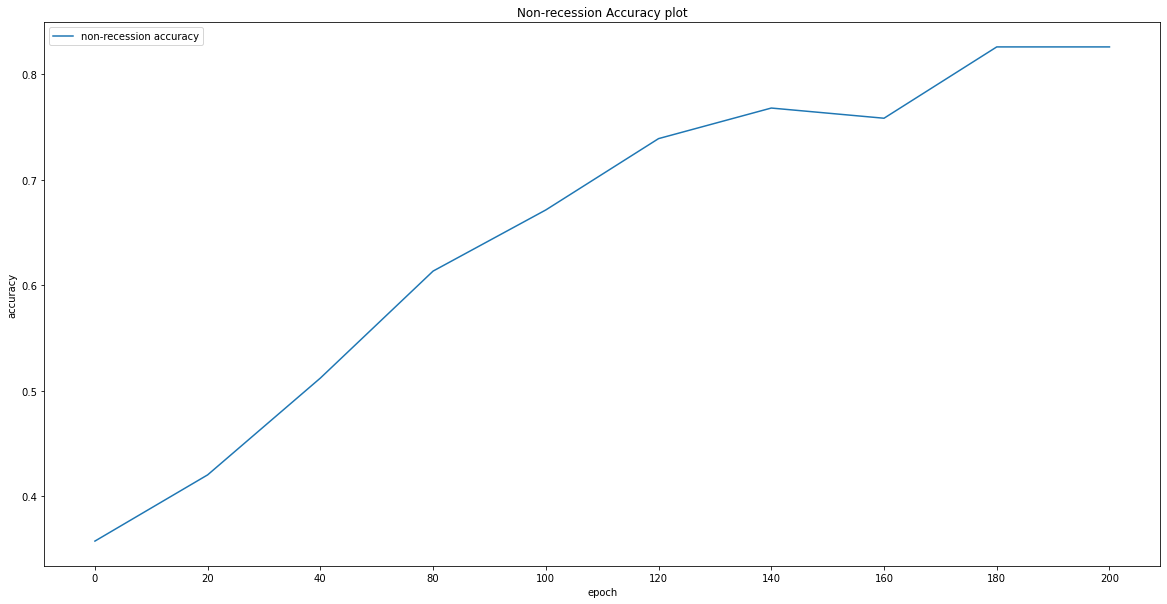

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

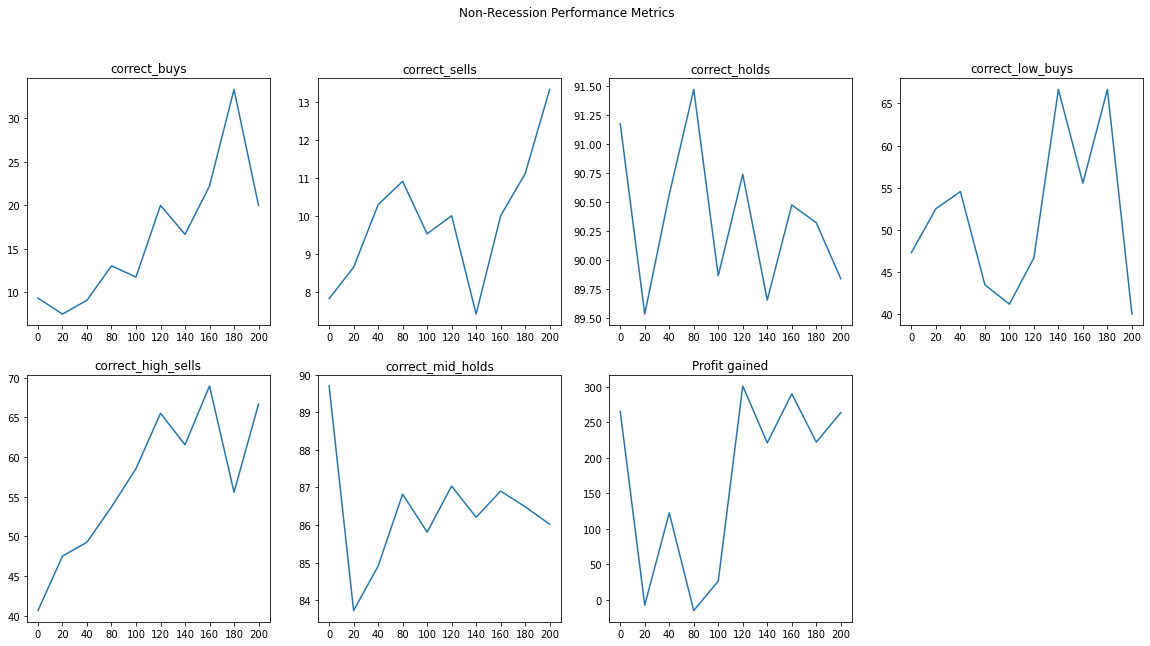

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

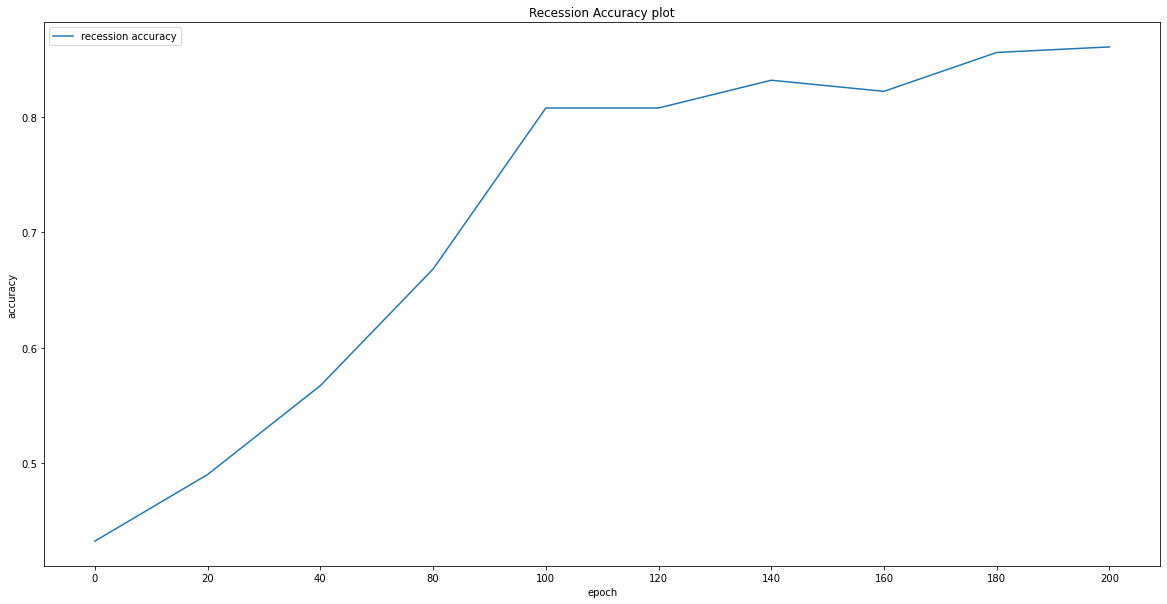

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

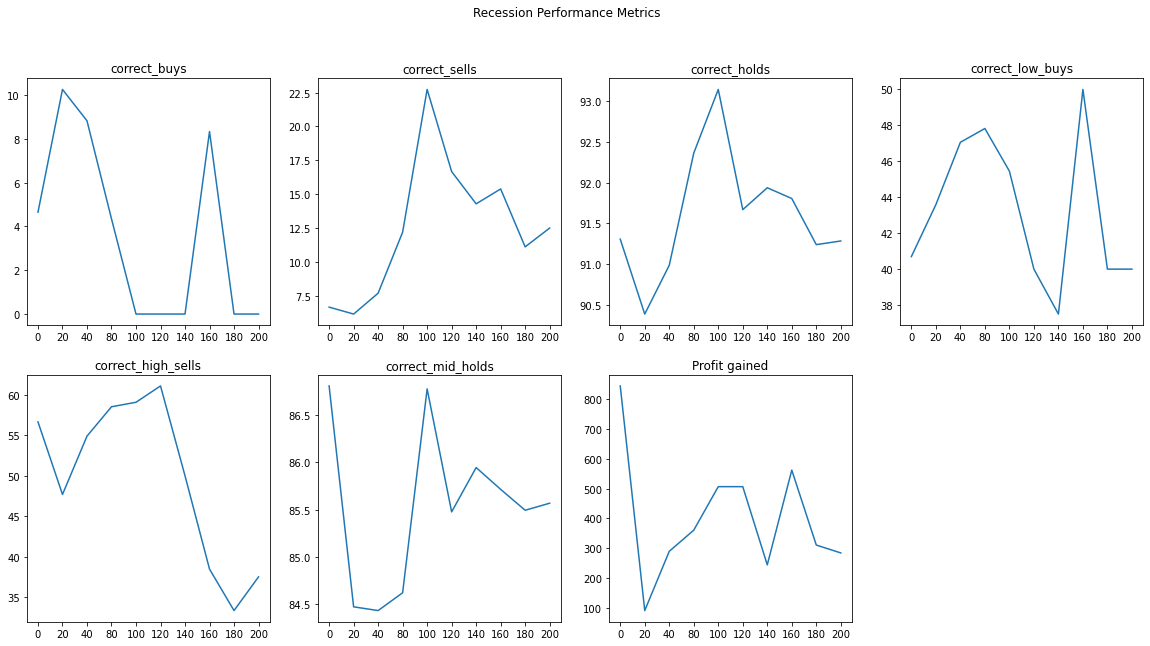

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Midea

In [22]:
nr_test_sets = ['000333.SZ']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-13    37.740002  38.759611 -71.929776  4.973847e+09     2.0
2018-12-14    40.119999  38.968901 -19.383280  5.047660e+09     2.0
2018-12-17    39.750000  39.089070 -27.533034  5.015177e+09     2.0
2018-12-18    39.459999  39.146136 -33.920718  4.984902e+09     2.0
2018-12-19    38.810001  39.094423 -48.237845  4.952096e+09     2.0


In [23]:
r_test_sets = ['000333.SZ']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2019-12-16    58.400002  56.667715  -2.074657  1.246874e+09     2.0
2019-12-17    58.110001  56.889605  -8.091274  1.225225e+09     0.0
2019-12-18    58.500000  57.137358  -8.538913  1.250810e+09     2.0
2019-12-19    58.200001  57.300842 -19.572930  1.227161e+09     2.0
2019-12-20    58.080002  57.420713 -23.018822  1.213685e+09     2.0


### training Data

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


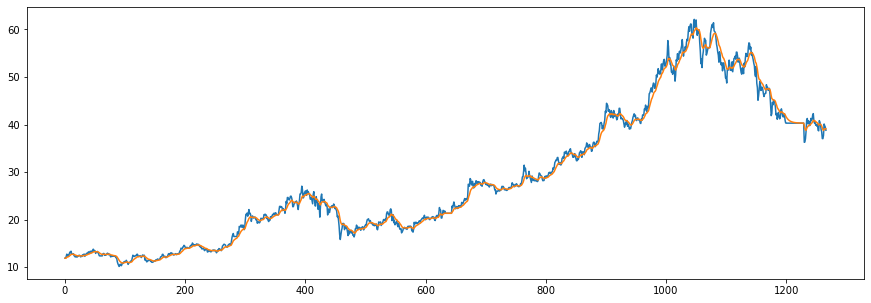

In [24]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('000333.SZ')]
    y = nr_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('000333.SZ'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('000333.SZ')]
    y = r_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2
 1 0 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2
 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0
 2 2 2 0 0 1 2 2 2 2 2 2 2 0 2 2 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 

{0: 7.920634920634921, 1: 6.789115646258503, 2: 0.3667769202499081}



RUNNING EPOCHS 0 - 20



Epoch 1/20
8/8 [==============================] - 1s 98ms/step - loss: 0.3437 - accuracy: 0.5802 - mse: 0.3429 - weighted_accuracy: 0.2923 - weighted_mse: 0.4559 - val_loss: 0.3032 - val_accuracy: 0.0440 - val_mse: 0.3396 - val_weighted_accuracy: 0.0440 - val_weighted_mse: 0.3396
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 0.2837 - accuracy: 0.5621 - mse: 0.4090 - weighted_accuracy: 0.3674 - weighted_mse: 0.4805 - val_loss: 0.3030 - val_accuracy: 0.0560 - val_mse: 0.3457 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 0.3457
Epoch 3/20
8/8 [==============================] - 0s 9ms/step - loss: 0.2491 - accuracy: 0.5200 - mse: 0.4914 - weighted_accuracy: 0.4178 - weighted_mse: 0.5324 - val_loss: 0.3012 - val_accuracy: 0.0480 - val_mse: 0.3500 - val_weighted_accuracy: 0.0480 - val_weighted_mse: 0.3500
Epoch 4/20
8/8 [==============================] - 0s 9ms/step -

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.25296199321746826
Test accuracy: 0.03365384787321091


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 193
actual holds but predicted sell: 0
actual predicted holds: 0
Percentage buys correct: 3.3653846153846154%
Percentage sells correct: 0%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 42.028985507246375%
Percentage high sells correct: 0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075




Capital at the end of test period: $568.5733088396158
profit gained: 468.5733088396159%


Capital at the end of test period if Buy and Hold: $568.5733088396158
profit gained: 468.5733088396159%
   Test_accuracy  cor

7/7 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.1202 - mse: 0.9154 - weighted_accuracy: 0.1202 - weighted_mse: 0.9154
Test loss: 0.2122185081243515
Test accuracy: 0.12019230425357819


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 3
actual sells but predicted hold: 0
actual holds but predicted buy: 116
actual holds but predicted sell: 62
actual predicted holds: 15
Percentage buys correct: 5.46875%
Percentage sells correct: 4.615384615384615%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 45.669291338582674%
Percentage high sells correct: 50.76923076923077%
Percentage mid holds correct: 73.33333333333333%


Capital: 100
Share price: $0.17350607819695518
Shares owned at the moment: 574
Cash capital at the moment: $0.1336317705138299


Price increase from previou

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.1242 - accuracy: 0.5511 - mse: 1.3795 - weighted_accuracy: 0.7933 - weighted_mse: 1.3346 - val_loss: 0.2112 - val_accuracy: 0.1120 - val_mse: 0.9447 - val_weighted_accuracy: 0.1120 - val_weighted_mse: 0.9447
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1223 - accuracy: 0.5381 - mse: 1.3963 - weighted_accuracy: 0.7961 - weighted_mse: 1.3522 - val_loss: 0.2091 - val_accuracy: 0.1440 - val_mse: 0.9611 - val_weighted_accuracy: 0.1440 - val_weighted_mse: 0.9611
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1211 - accuracy: 0.5551 - mse: 1.3976 - weighted_accuracy: 0.8024 - weighted_mse: 1.3644 - val_loss: 0.2056 - val_accuracy: 0.1880 - val_mse: 0.9820 - val_weighted_accuracy: 0.1880 - val_weighted_mse: 0.9820
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 0.1211 - accuracy: 0.5521 - mse: 1.3996 - weighted_accuracy: 0.7861 - weighted_mse: 1.349

7/7 [==============================] - 0s 3ms/step - loss: 0.1812 - accuracy: 0.3846 - mse: 1.1731 - weighted_accuracy: 0.3846 - weighted_mse: 1.1731
Test loss: 0.18123483657836914
Test accuracy: 0.38461539149284363


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 58
actual holds but predicted sell: 62
actual predicted holds: 73
Percentage buys correct: 7.575757575757576%
Percentage sells correct: 3.125%
Percentage holds correct: 93.58974358974359%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 43.93939393939394%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 85.8974358974359%


Capital: 100
Share price: $0.14716810887303755
Shares owned at the moment: 677
Cash capital at the moment: $0.0932000662592003


Price increase from

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


Cash capital at the moment: $114.35185318835867


Share price: $0.2847577152776136
Shares owned at the moment: 400
Cash capital at the moment: $0.13553359050784763


Price increase from previously bought: 34.99790068838988%
Share price: $0.3854740842516017
Shares owned at the moment: 0
Cash capital at the moment: $153.90114579847176


Share price: $0.31868095225005233
Shares owned at the moment: 481
Cash capital at the moment: $0.19407253660781976


Price increase from previously bought: 70.54117606940503%
Share price: $0.5449768200470785
Shares owned at the moment: 0
Cash capital at the moment: $261.6070548905353


Share price: $0.5475053229736894
Shares owned at the moment: 476
Cash capital at the moment: $0.27783668728665134


Price increase from previously bought: -8.026777439622624%
Share price: $0.5049430745238827
Shares owned at the moment: 0
Cash capital at the moment: $239.96976967610303


Share price: $0.6427433493171243
Shares owned at the moment: 372
Cash capital at the mo

Shares owned at the moment: 1384
Cash capital at the moment: $0.11672546668694395


Price increase from previously bought: 63.63795495845115%
Share price: $0.9608080965946784
Shares owned at the moment: 0
Cash capital at the moment: $1326.2182955380822


Share price: $0.7787982416470054
Shares owned at the moment: 1698
Cash capital at the moment: $0.1822828320964618


Price increase from previously bought: 2.065423048607018%
Share price: $0.7970696502622172
Shares owned at the moment: 0
Cash capital at the moment: $1349.884632245442




Capital at the end of test period: $1349.884632245442
profit gained: 1249.884632245442%


Capital at the end of test period if Buy and Hold: $1345.2754815401652
profit gained: 1245.2754815401652%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0        0.47343      6.944444      10.810811      90.816327   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         55.555556           45.945946          80.412

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 3
actual predicted sells: 1
actual sells but predicted hold: 4
actual holds but predicted buy: 40
actual holds but predicted sell: 34
actual predicted holds: 119
Percentage buys correct: 4.444444444444445%
Percentage sells correct: 2.857142857142857%
Percentage holds correct: 92.96875%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 67.6470588235294%
Percentage mid holds correct: 86.71875%


Capital: 100
Share price: $0.14716810887303755
Shares owned at the moment: 677
Cash capital at the moment: $0.0932000662592003


Price increase from previously bought: 11.719235401176853%
Share price: $0.16486722747379423
Shares owned at the moment: 0
Cash capital at the moment: $111.40137150526856


Share price: $0.061833104338965154
Shares owned at the moment: 1796
C

Epoch 15/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0749 - accuracy: 0.7685 - mse: 2.0537 - weighted_accuracy: 0.9151 - weighted_mse: 2.1028 - val_loss: 0.1685 - val_accuracy: 0.6320 - val_mse: 2.0724 - val_weighted_accuracy: 0.6320 - val_weighted_mse: 2.0724
Epoch 16/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0757 - accuracy: 0.7745 - mse: 2.0730 - weighted_accuracy: 0.9173 - weighted_mse: 2.1437 - val_loss: 0.1623 - val_accuracy: 0.6600 - val_mse: 2.0219 - val_weighted_accuracy: 0.6600 - val_weighted_mse: 2.0219
Epoch 17/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0743 - accuracy: 0.7685 - mse: 2.0858 - weighted_accuracy: 0.9151 - weighted_mse: 2.1243 - val_loss: 0.1657 - val_accuracy: 0.6240 - val_mse: 2.0241 - val_weighted_accuracy: 0.6240 - val_weighted_mse: 2.0241
Epoch 18/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0730 - accuracy: 0.7615 - mse: 2.1091 - weighted_accuracy: 0.9125 - weighted_mse: 2

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 28
actual holds but predicted sell: 35
actual predicted holds: 130
Percentage buys correct: 0.0%
Percentage sells correct: 2.7777777777777777%
Percentage holds correct: 90.9090909090909%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.172413793103445%
Percentage high sells correct: 63.888888888888886%
Percentage mid holds correct: 83.80281690140845%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: 14.308704712687659%
Share price: $0.19984404752087281
Shares owned at the moment: 0
Cash capital at the moment: $113.97014559811012


Share price: $0.061833104338965154
Shares owned at the moment:

Epoch 19/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0584 - accuracy: 0.8236 - mse: 2.6361 - weighted_accuracy: 0.9353 - weighted_mse: 2.6470 - val_loss: 0.1683 - val_accuracy: 0.7120 - val_mse: 2.8606 - val_weighted_accuracy: 0.7120 - val_weighted_mse: 2.8606
Epoch 20/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0570 - accuracy: 0.8387 - mse: 2.6543 - weighted_accuracy: 0.9408 - weighted_mse: 2.6757 - val_loss: 0.1783 - val_accuracy: 0.6800 - val_mse: 2.8610 - val_weighted_accuracy: 0.6800 - val_weighted_mse: 2.8610
Validation loss: 0.17832434177398682
Validation accuracy: 0.6800000071525574


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1516 - accuracy: 0.6667 - mse: 2.6057 - weighted_accuracy: 0.6667 - weighted_mse: 2.6057
Test loss: 0.15164698660373688
Test accuracy: 0.6666666865348816


number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10


<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
8/8 [==============================] - 0s 12ms/step - loss: 0.0571 - accuracy: 0.8327 - mse: 2.6993 - weighted_accuracy: 0.9386 - weighted_mse: 2.7326 - val_loss: 0.1834 - val_accuracy: 0.6560 - val_mse: 3.0029 - val_weighted_accuracy: 0.6560 - val_weighted_mse: 3.0029
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0564 - accuracy: 0.8297 - mse: 2.7417 - weighted_accuracy: 0.9375 - weighted_mse: 2.7696 - val_loss: 0.1619 - val_accuracy: 0.7360 - val_mse: 3.0464 - val_weighted_accuracy: 0.7360 - val_weighted_mse: 3.0464
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0554 - accuracy: 0.8417 - mse: 2.7461 - weighted_accuracy: 0.9419 - weighted_mse: 2.8061 - val_loss: 0.1794 - val_accuracy: 0.6800 - val_mse: 3.0931 - val_weighted_accuracy: 0.6800 - val_weighted_mse: 3.0931
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0555 - accuracy: 0.8447 - mse: 2.7768 - weighted_accuracy: 0.9430 - weighted_mse: 2.7

7/7 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.7163 - mse: 3.1601 - weighted_accuracy: 0.7163 - weighted_mse: 3.1601
Test loss: 0.17845891416072845
Test accuracy: 0.7163461446762085


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 26
actual predicted holds: 148
Percentage buys correct: 0.0%
Percentage sells correct: 3.7037037037037037%
Percentage holds correct: 91.92546583850931%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 60.0%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: -72

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 140 - 160



Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0459 - accuracy: 0.8667 - mse: 3.3163 - weighted_accuracy: 0.9511 - weighted_mse: 3.2855 - val_loss: 0.1941 - val_accuracy: 0.6920 - val_mse: 3.6720 - val_weighted_accuracy: 0.6920 - val_weighted_mse: 3.6720
Epoch 2/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0458 - accuracy: 0.8707 - mse: 3.3782 - weighted_accuracy: 0.9526 - weighted_mse: 3.3156 - val_loss: 0.1724 - val_accuracy: 0.7680 - val_mse: 3.8128 - val_weighted_accuracy: 0.7680 - val_weighted_mse: 3.8128
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 0.0442 - accuracy: 0.8808 - mse: 3.3924 - weighted_accuracy: 0.9563 - weighted_mse: 3.3600 - val_loss: 0.2001 - val_accuracy: 0.7040 - val_mse: 3.7686 - val_weighted_accuracy: 0.7040 - val_weighted_mse: 3.7686
Epoch 4/20
8/8 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.8758 - mse: 3.4248 - weighted_accura

0        1245.275482  


Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1958 - accuracy: 0.6875 - mse: 3.7115 - weighted_accuracy: 0.6875 - weighted_mse: 3.7115
Test loss: 0.1958102434873581
Test accuracy: 0.6875


number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 20
actual holds but predicted sell: 31
actual predicted holds: 142
Percentage buys correct: 0.0%
Percentage sells correct: 3.125%
Percentage holds correct: 91.61290322580645%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 61.904761904761905%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 84.41558441558442%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0365 - accuracy: 0.9028 - mse: 4.0438 - weighted_accuracy: 0.9644 - weighted_mse: 3.8723 - val_loss: 0.2110 - val_accuracy: 0.7080 - val_mse: 4.3802 - val_weighted_accuracy: 0.7080 - val_weighted_mse: 4.3802
Epoch 2/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0370 - accuracy: 0.8988 - mse: 4.1159 - weighted_accuracy: 0.9629 - weighted_mse: 3.8909 - val_loss: 0.1914 - val_accuracy: 0.7720 - val_mse: 4.5984 - val_weighted_accuracy: 0.7720 - val_weighted_mse: 4.5984
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0354 - accuracy: 0.9058 - mse: 4.1417 - weighted_accuracy: 0.9655 - weighted_mse: 3.9439 - val_loss: 0.2251 - val_accuracy: 0.7160 - val_mse: 4.5103 - val_weighted_accuracy: 0.7160 - val_weighted_mse: 4.5103
Epoch 4/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0358 - accuracy: 0.9058 - mse: 4.1712 - weighted_accuracy: 0.9655 - weighted_mse: 3.9

7/7 [==============================] - 0s 3ms/step - loss: 0.1936 - accuracy: 0.7115 - mse: 4.4001 - weighted_accuracy: 0.7115 - weighted_mse: 4.4001
Test loss: 0.19361740350723267
Test accuracy: 0.7115384340286255




<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 26
actual holds but predicted sell: 19
actual predicted holds: 148
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 91.35802469135803%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 83.22981366459628%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: -72.10435955117971%
Share price: $0.04876949405989072
Shares owned at the moment: 0
Cash capital at the moment: $27.943800389461465


Share price: $0.08416773126140474
Shares owned at the moment: 331
Cash capital

Epoch 20/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - accuracy: 0.9409 - mse: 5.8203 - weighted_accuracy: 0.9783 - weighted_mse: 5.0611 - val_loss: 0.2484 - val_accuracy: 0.7400 - val_mse: 6.1225 - val_weighted_accuracy: 0.7400 - val_weighted_mse: 6.1225
Validation loss: 0.24842852354049683
Validation accuracy: 0.7400000095367432


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.7826 - mse: 5.2166 - weighted_accuracy: 0.7826 - weighted_mse: 5.2166
Test loss: 0.15655368566513062
Test accuracy: 0.782608687877655


number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 14
actual holds but predicted sell: 14
actual predicted holds: 158
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 17.647058823529413

<ipython-input-29-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.033654,3.365385,0.000000,0.000000,42.028986,0.000000,0.000000,468.573309,468.573309
1,0.120192,5.468750,4.615385,100.000000,45.669291,50.769231,73.333333,124.594542,468.573309
2,0.384615,7.575758,3.125000,93.589744,43.939394,55.555556,85.897436,245.848073,468.573309
3,0.586538,4.444444,2.857143,92.968750,44.444444,67.647059,86.718750,1347.728463,468.573309
4,0.629808,0.000000,2.777778,90.909091,55.172414,63.888889,83.802817,198.885444,468.573309
5,0.682692,0.000000,2.857143,91.558442,57.894737,54.285714,84.313725,122.960142,468.573309
6,0.716346,0.000000,3.703704,91.925466,60.000000,51.851852,84.375000,-49.660435,468.573309
7,0.687500,0.000000,3.125000,91.612903,61.904762,56.250000,84.415584,-28.722869,468.573309
8,0.711538,0.000000,0.000000,91.358025,55.555556,47.368421,83.229814,54.936271,468.573309
9,0.735577,0.000000,0.000000,91.616766,57.894737,54.545455,83.734940,59.531708,468.573309


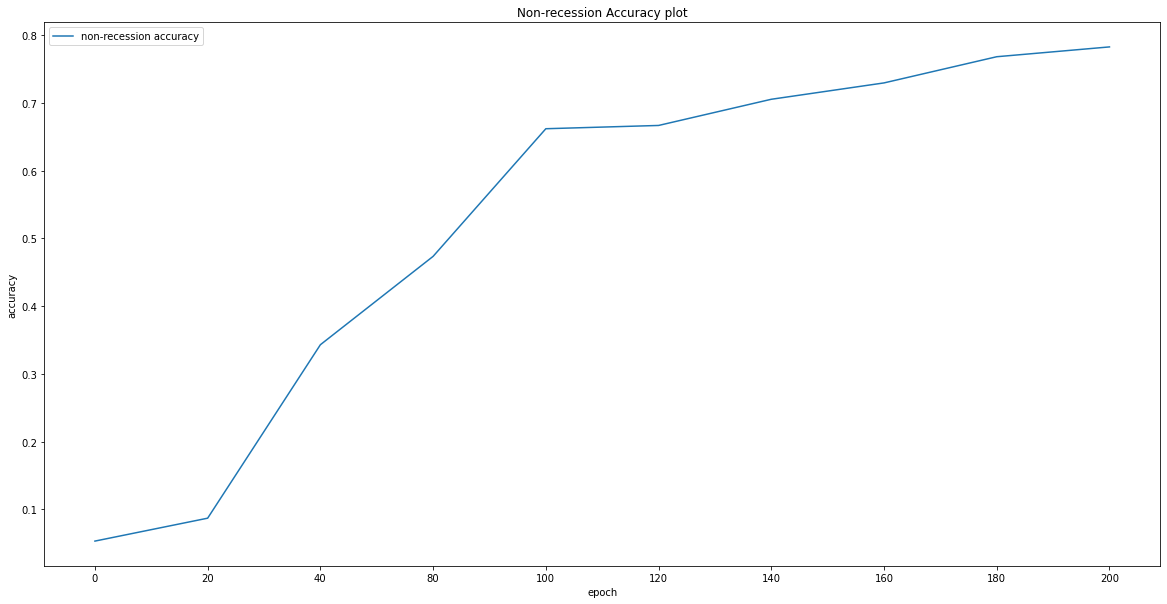

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

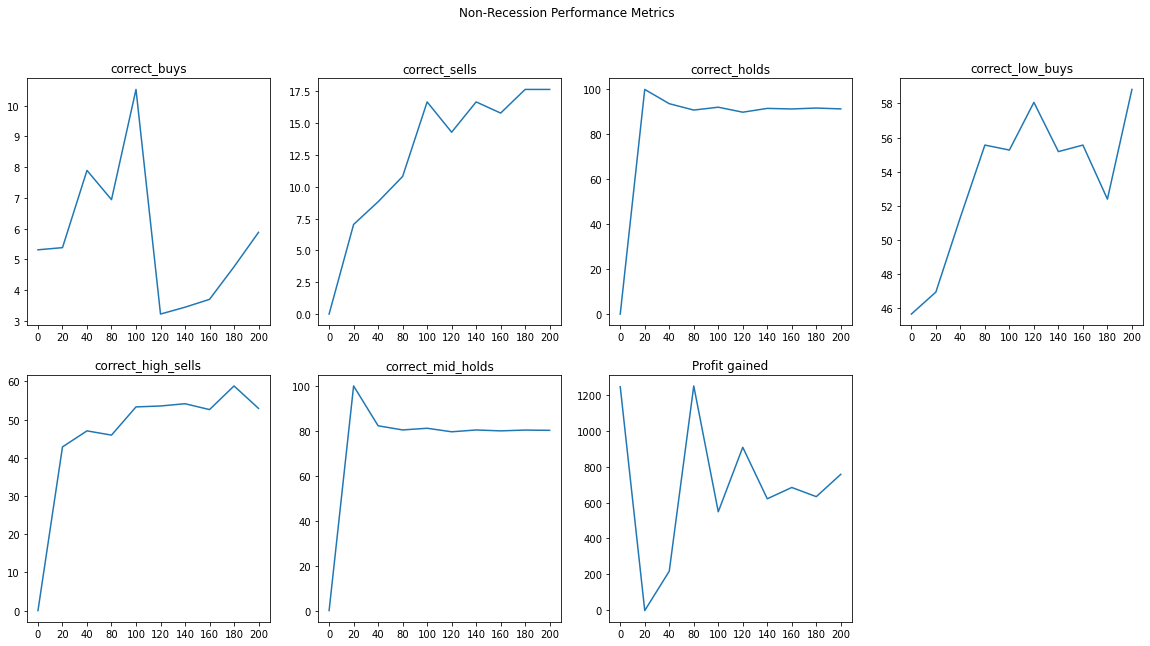

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

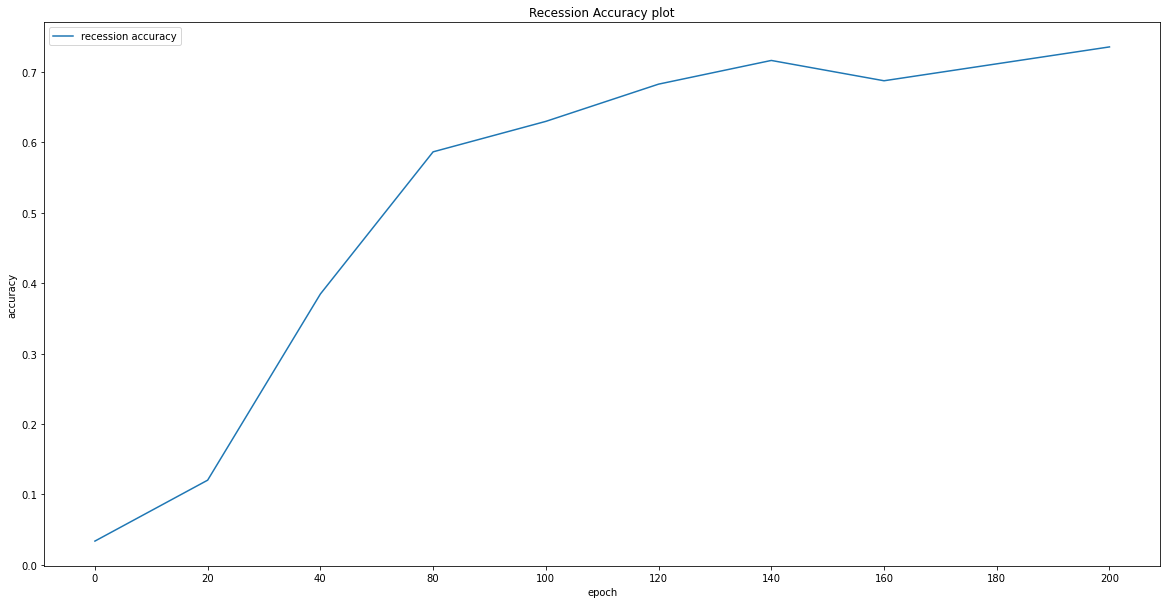

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

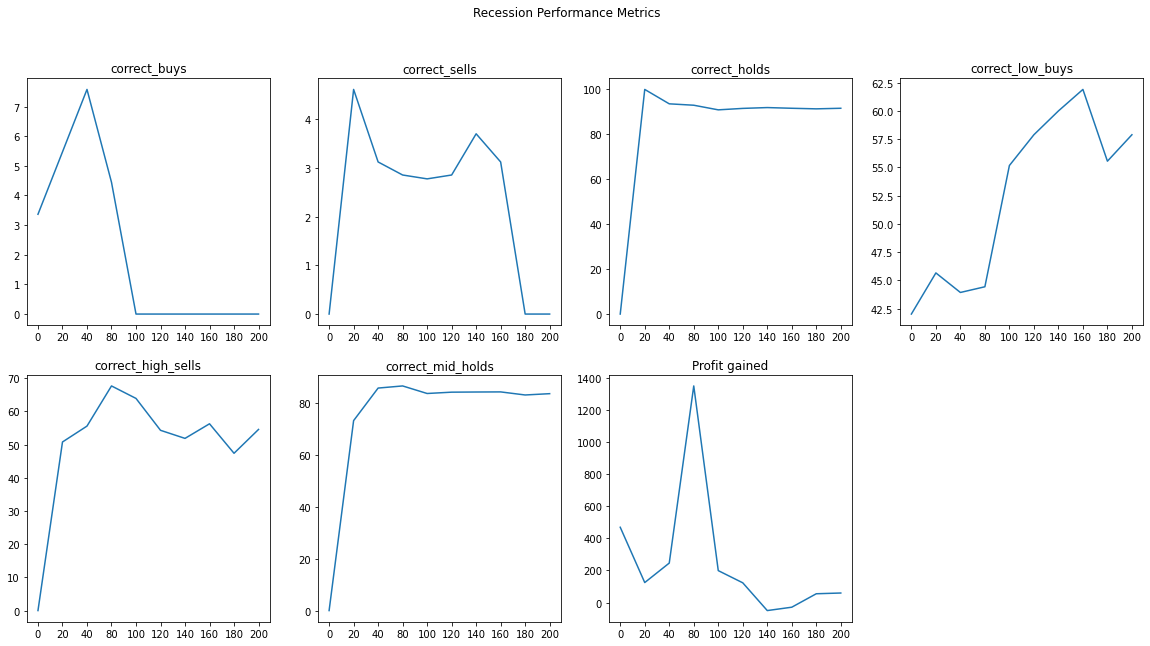

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Walmart

In [35]:
nr_test_sets = ['WMT']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2018-12-13    93.110001  95.261110 -89.379251  98530500.0     2.0
2018-12-14    92.959999  94.907093 -91.448238  90488200.0     2.0
2018-12-17    91.849998  94.436771 -96.508742  78994600.0     2.0
2018-12-18    90.769997  93.872652 -93.531353  69992800.0     2.0
2018-12-19    91.080002  93.443013 -90.243914  79599500.0     2.0


In [36]:
r_test_sets = ['WMT']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-13   119.760002  119.241902 -18.750000  211183700.0     2.0
2019-12-16   120.290001  119.403148 -11.145518  216550000.0     2.0
2019-12-17   120.540001  119.578049 -20.610623  221900700.0     0.0
2019-12-18   121.279999  119.839887  -9.813044  226476500.0     2.0
2019-12-19   119.860001  119.842981 -42.990581  221373500.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


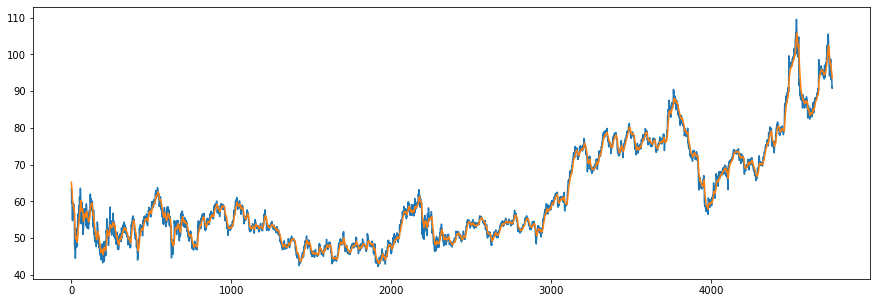

In [37]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/WMT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('WMT')]
    y = nr_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('WMT'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('WMT')]
    y = r_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.141242937853107, 1: 7.348837209302325, 2: 0.36712169619517865}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 34ms/step - loss: 0.2919 - accuracy: 0.5076 - mse: 0.4540 - weighted_accuracy: 0.3034 - weighted_mse: 0.5275 - val_loss: 0.2988 - val_accuracy: 0.0485 - val_mse: 0.3562 - val_weighted_accuracy: 0.0485 - val_weighted_mse: 0.3562
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2109 - accuracy: 0.4048 - mse: 0.7609 - weighted_accuracy: 0.4047 - weighted_mse: 0.7780 - val_loss: 0.2895 - val_accuracy: 0.0454 - val_mse: 0.3832 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3832
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.2851 - mse: 1.0220 - weighted_accuracy: 0.4419 - weighted_mse: 1.0026 - val_loss: 0.2795 - val_accuracy: 0.0454 - val_mse: 0.4192 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4192
Epoch 4/20
30/30 [==============================] - 0s 7

7/7 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.4840 - mse: 1.1495 - weighted_accuracy: 0.4840 - weighted_mse: 1.1495


<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1751985400915146
Test accuracy: 0.4840182662010193


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 65
actual holds but predicted sell: 39
actual predicted holds: 97
Percentage buys correct: 6.944444444444445%
Percentage sells correct: 9.30232558139535%
Percentage holds correct: 93.26923076923077%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 55.81395348837209%
Percentage mid holds correct: 84.46601941747574%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from previously bought: 319.5821818842188%
Share price: $0.5902216751235991
Shares owned at the moment: 0
Cash capital at the moment: $418.030

Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1350 - accuracy: 0.4172 - mse: 1.7079 - weighted_accuracy: 0.7227 - weighted_mse: 1.6163 - val_loss: 0.1901 - val_accuracy: 0.3861 - val_mse: 1.6694 - val_weighted_accuracy: 0.3861 - val_weighted_mse: 1.6694
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1346 - accuracy: 0.4422 - mse: 1.6991 - weighted_accuracy: 0.7192 - weighted_mse: 1.6186 - val_loss: 0.1892 - val_accuracy: 0.3650 - val_mse: 1.7449 - val_weighted_accuracy: 0.3650 - val_weighted_mse: 1.7449
Epoch 19/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1340 - accuracy: 0.4254 - mse: 1.7271 - weighted_accuracy: 0.7276 - weighted_mse: 1.6315 - val_loss: 0.1908 - val_accuracy: 0.3703 - val_mse: 1.6833 - val_weighted_accuracy: 0.3703 - val_weighted_mse: 1.6833
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1326 - accuracy: 0.4597 - mse: 1.7194 - weighted_accuracy: 0.7419 - weighted

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 58
actual holds but predicted sell: 43
actual predicted holds: 100
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 14.0%
Percentage holds correct: 93.45794392523365%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 59.01639344262295%
Percentage high sells correct: 58.0%
Percentage mid holds correct: 85.98130841121495%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 55.06714096943164%
Share price: $0.325962186747079
Shares owned at the moment: 0
Cash capital at the moment: $154.55786380487092


Share price: $0.21988916243820156
Shares owned at the moment: 700
Cash capital

30/30 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.5599 - mse: 1.9970 - weighted_accuracy: 0.7860 - weighted_mse: 1.9349 - val_loss: 0.1951 - val_accuracy: 0.4146 - val_mse: 2.0622 - val_weighted_accuracy: 0.4146 - val_weighted_mse: 2.0622
Epoch 19/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1185 - accuracy: 0.5340 - mse: 2.0262 - weighted_accuracy: 0.7728 - weighted_mse: 1.9455 - val_loss: 0.1867 - val_accuracy: 0.4631 - val_mse: 2.0111 - val_weighted_accuracy: 0.4631 - val_weighted_mse: 2.0111
Epoch 20/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1170 - accuracy: 0.5665 - mse: 2.0192 - weighted_accuracy: 0.7956 - weighted_mse: 1.9688 - val_loss: 0.1887 - val_accuracy: 0.4473 - val_mse: 2.1672 - val_weighted_accuracy: 0.4473 - val_weighted_mse: 2.1672
Validation loss: 0.1887410283088684
Validation accuracy: 0.4472573697566986


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.177

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1152 - accuracy: 0.5501 - mse: 2.0746 - weighted_accuracy: 0.8042 - weighted_mse: 2.0024 - val_loss: 0.1831 - val_accuracy: 0.4641 - val_mse: 2.0304 - val_weighted_accuracy: 0.4641 - val_weighted_mse: 2.0304
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.5952 - mse: 2.0713 - weighted_accuracy: 0.8151 - weighted_mse: 2.0213 - val_loss: 0.1960 - val_accuracy: 0.4135 - val_mse: 2.1777 - val_weighted_accuracy: 0.4135 - val_weighted_mse: 2.1777
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1139 - accuracy: 0.5456 - mse: 2.1182 - weighted_accuracy: 0.7846 - weighted_mse: 2.0511 - val_loss: 0.1771 - val_accuracy: 0.5084 - val_mse: 2.2261 - val_weighted_accuracy: 0.5084 - val_weighted_mse: 2.2261
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1127 - accuracy: 0.5773 - mse: 2.1174 - weighted_accuracy: 0.8086 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1585 - accuracy: 0.6073 - mse: 2.8688 - weighted_accuracy: 0.6073 - weighted_mse: 2.8688
Test loss: 0.1584518849849701
Test accuracy: 0.6073059439659119


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 42
actual holds but predicted sell: 34
actual predicted holds: 125
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 12.820512820512821%
Percentage holds correct: 92.5925925925926%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.36363636363637%
Percentage high sells correct: 51.282051282051285%
Percentage mid holds correct: 85.92592592592592%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




RUNNING EPOCHS 80 - 100



Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0997 - accuracy: 0.6398 - mse: 2.4782 - weighted_accuracy: 0.8497 - weighted_mse: 2.4190 - val_loss: 0.1800 - val_accuracy: 0.5538 - val_mse: 2.3415 - val_weighted_accuracy: 0.5538 - val_weighted_mse: 2.3415
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0988 - accuracy: 0.6741 - mse: 2.4814 - weighted_accuracy: 0.8622 - weighted_mse: 2.4454 - val_loss: 0.1887 - val_accuracy: 0.5063 - val_mse: 2.6930 - val_weighted_accuracy: 0.5063 - val_weighted_mse: 2.6930
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0988 - accuracy: 0.6355 - mse: 2.5259 - weighted_accuracy: 0.8301 - weighted_mse: 2.4867 - val_loss: 0.1754 - val_accuracy: 0.5759 - val_mse: 2.6824 - val_weighted_accuracy: 0.5759 - val_weighted_mse: 2.6824
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0980 - accuracy: 0.6519 - mse: 2.5584 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1553 - accuracy: 0.6986 - mse: 3.7574 - weighted_accuracy: 0.6986 - weighted_mse: 3.7574
Test loss: 0.15531429648399353
Test accuracy: 0.698630154132843




<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 34
actual holds but predicted sell: 22
actual predicted holds: 145
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 18.51851851851852%
Percentage holds correct: 93.54838709677419%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 48.148148148148145%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 79.85853753314063%
Share price: $0.37807546997330177
Shares owned at the moment: 0
Cash capital at the moment: $179.2436003611125


Share price: $0.4111079060203673
Shares owned at 

30/30 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.7758 - mse: 3.6175 - weighted_accuracy: 0.9015 - weighted_mse: 3.5549 - val_loss: 0.1870 - val_accuracy: 0.6086 - val_mse: 4.2051 - val_weighted_accuracy: 0.6086 - val_weighted_mse: 4.2051
Validation loss: 0.1869947910308838
Validation accuracy: 0.6086497902870178


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.6835 - mse: 4.7177 - weighted_accuracy: 0.6835 - weighted_mse: 4.7177
Test loss: 0.1606225222349167
Test accuracy: 0.6834862232208252


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 22
actual holds but predicted sell: 37
actual predicted holds: 143
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 9.75609756097561%
Percentage h

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 29
actual holds but predicted sell: 18
actual predicted holds: 154
Percentage buys correct: 9.375%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 92.7710843373494%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.064516129032256%
Percentage high sells correct: 38.095238095238095%
Percentage mid holds correct: 86.144578313253%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 79.85853753314063%
Share price: $0.37807546997330177
Shares owned at the moment: 0
Cash capital at the moment: $179.2436003611125


Share price: $0.4111079060203673
Shares owned at the moment: 43

30/30 [==============================] - 0s 8ms/step - loss: 0.0621 - accuracy: 0.8149 - mse: 4.4744 - weighted_accuracy: 0.9248 - weighted_mse: 4.3199 - val_loss: 0.1924 - val_accuracy: 0.6519 - val_mse: 4.8967 - val_weighted_accuracy: 0.6519 - val_weighted_mse: 4.8967
Validation loss: 0.19240953028202057
Validation accuracy: 0.6518987417221069


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.7156 - mse: 5.5585 - weighted_accuracy: 0.7156 - weighted_mse: 5.5585
Test loss: 0.16452008485794067
Test accuracy: 0.7155963182449341


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 19
actual holds but predicted sell: 31
actual predicted holds: 152
Percentage buys correct: 5.0%
Percentage sells correct: 8.823529411764707%
Percentage holds correc

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0609 - accuracy: 0.8017 - mse: 4.5293 - weighted_accuracy: 0.9236 - weighted_mse: 4.3733 - val_loss: 0.1922 - val_accuracy: 0.6435 - val_mse: 4.6759 - val_weighted_accuracy: 0.6435 - val_weighted_mse: 4.6759
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0615 - accuracy: 0.8146 - mse: 4.6062 - weighted_accuracy: 0.9302 - weighted_mse: 4.4256 - val_loss: 0.1920 - val_accuracy: 0.6508 - val_mse: 5.0908 - val_weighted_accuracy: 0.6508 - val_weighted_mse: 5.0908
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0599 - accuracy: 0.8138 - mse: 4.6648 - weighted_accuracy: 0.9280 - weighted_mse: 4.5301 - val_loss: 0.1922 - val_accuracy: 0.6814 - val_mse: 5.1255 - val_weighted_accuracy: 0.6814 - val_weighted_mse: 5.1255
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0612 - accuracy: 0.8178 - mse: 4.6340 - weighted_accuracy: 0.9258 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.7808 - mse: 7.2177 - weighted_accuracy: 0.7808 - weighted_mse: 7.2177
Test loss: 0.16057957708835602
Test accuracy: 0.7808219194412231




<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 25
actual holds but predicted sell: 10
actual predicted holds: 166
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 92.73743016759776%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 59.25925925925926%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 86.59217877094972%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 78.39446431549257%
Share price: $0.3749978836800427
Shares owned at the moment: 0
Cash capital at the moment: $177.78576696891002


Share price: $0.4111079060203673
Shares owned at

7/7 [==============================] - 0s 3ms/step - loss: 0.1847 - accuracy: 0.7477 - mse: 8.2410 - weighted_accuracy: 0.7477 - weighted_mse: 8.2410
Test loss: 0.18472698330879211
Test accuracy: 0.747706413269043


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 17
actual holds but predicted sell: 26
actual predicted holds: 159
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 10.344827586206897%
Percentage holds correct: 92.98245614035088%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 50.0%
Percentage high sells correct: 62.06896551724138%
Percentage mid holds correct: 85.88235294117646%


Capital: 100
Share price: $0.2376717024317323
Shares owned at the moment: 419
Cash capital at the moment: $0.14169946197719696


Price increase from

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 22
actual holds but predicted sell: 8
actual predicted holds: 171
Percentage buys correct: 12.0%
Percentage sells correct: 0.0%
Percentage holds correct: 91.93548387096774%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 86.55913978494624%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from previously bought: 123.55522750779132%
Share price: $0.3144726982202879
Shares owned at the moment: 0
Cash capital at the moment: $222.7866828247016


Share price: $0.5448788939034961
Shares owned at the moment: 407
Cash capital at the mome

7/7 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.7945 - mse: 9.8271 - weighted_accuracy: 0.7945 - weighted_mse: 9.8271
Test loss: 0.16137348115444183
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 11
actual holds but predicted buy: 20
actual holds but predicted sell: 10
actual predicted holds: 171
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 0.0%
Percentage holds correct: 91.93548387096774%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 86.55913978494624%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from previousl

<ipython-input-42-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-42-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-42-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

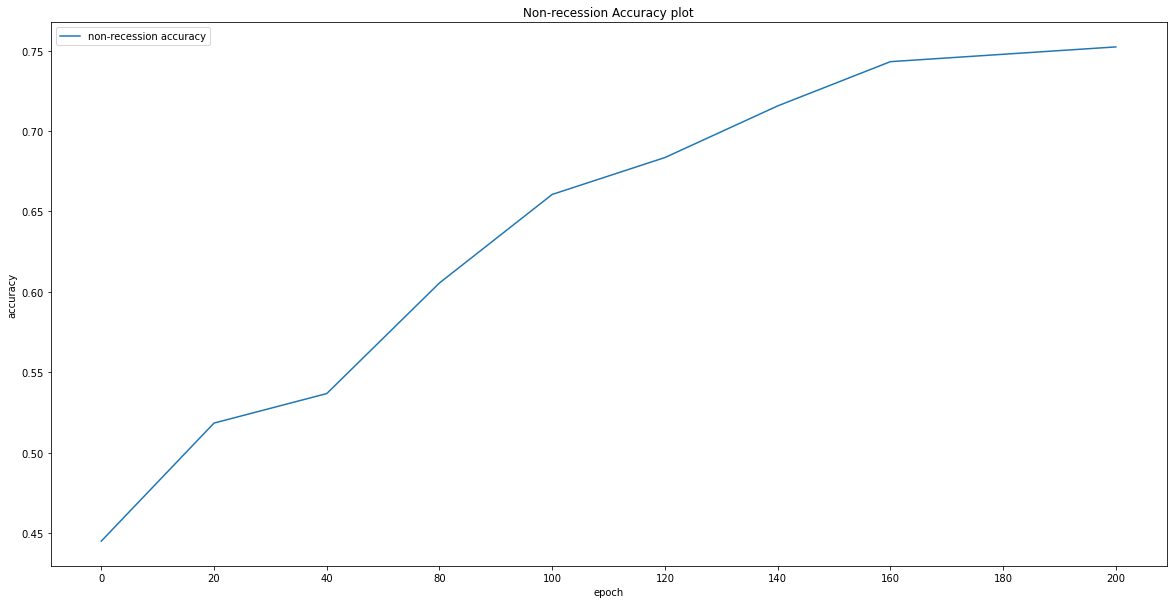

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

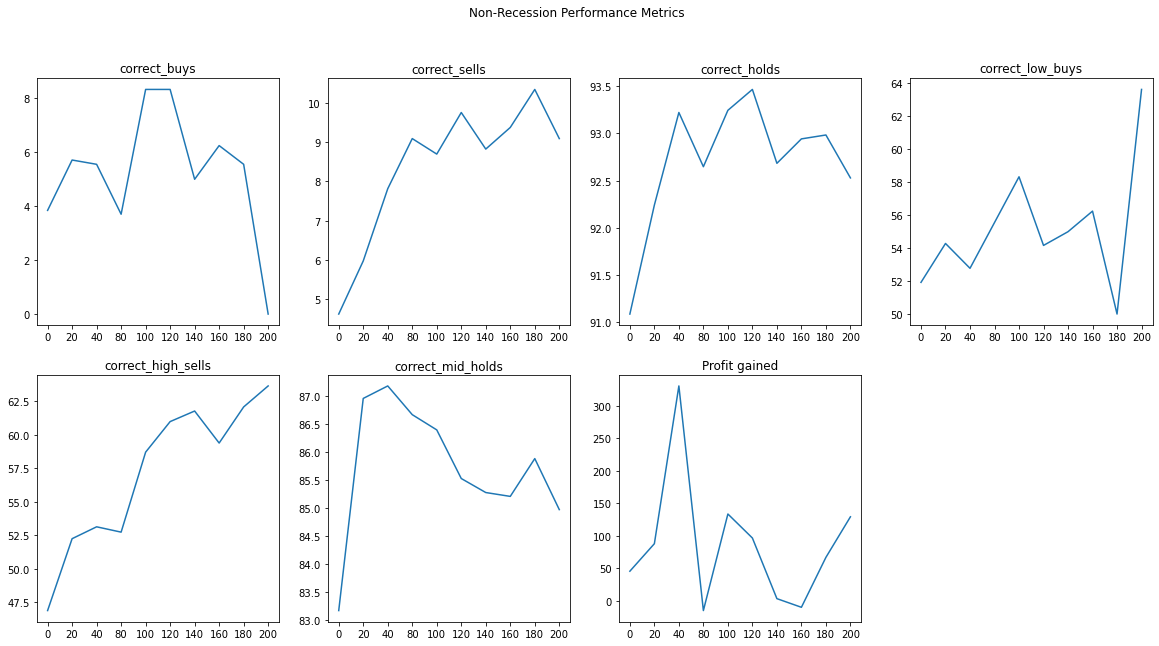

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

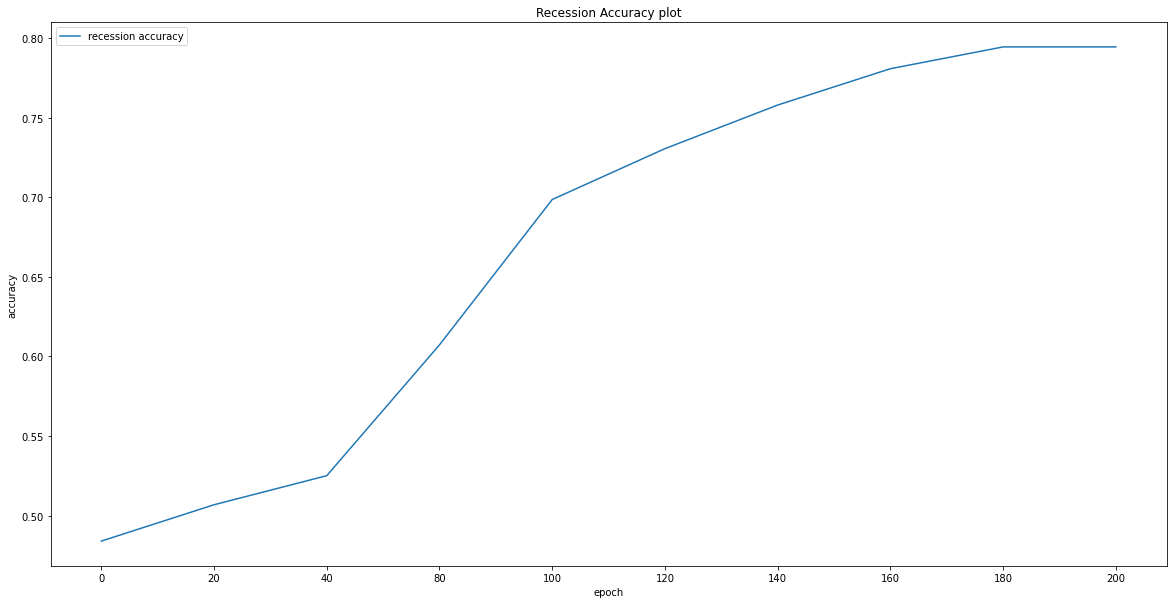

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

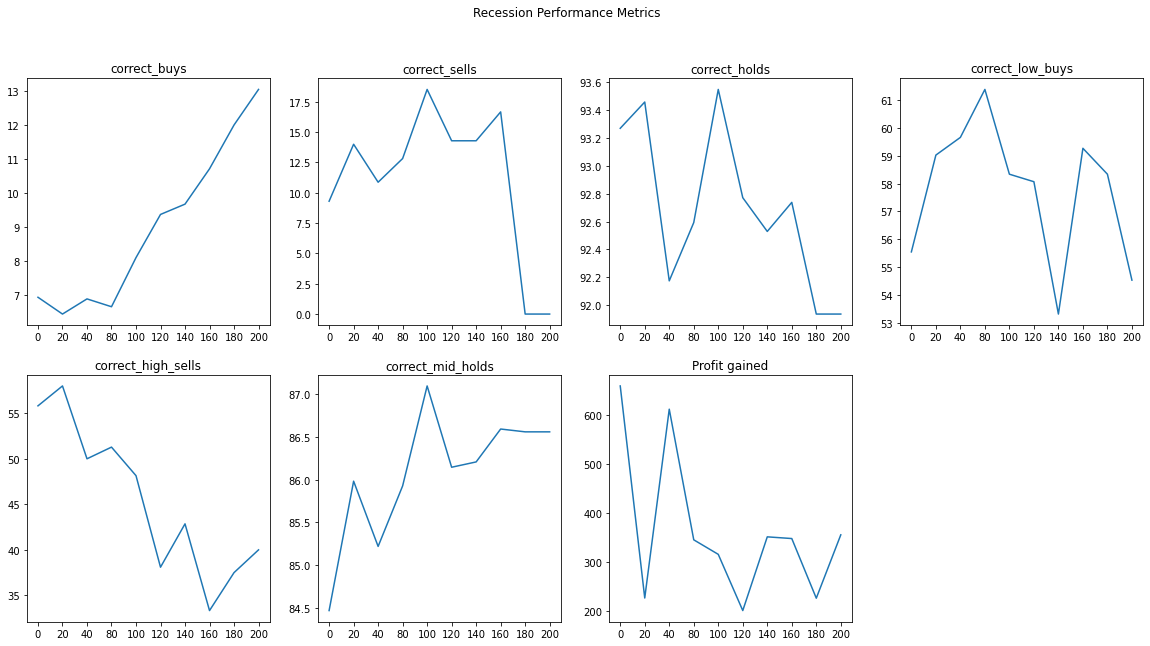

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Fresh Del Monte Produce Inc (small cap)

In [47]:
nr_test_sets = ['FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2018-12-13    33.090000  32.210365 -29.500008  41799100.0     0.0
2018-12-14    33.310001  32.379540 -23.999977  42032900.0     2.0
2018-12-17    32.500000  32.398072 -44.923863  41904100.0     2.0
2018-12-18    32.150002  32.359908 -55.064902  41601100.0     2.0
2018-12-19    30.770000  32.115306 -94.085991  41369900.0     2.0


In [48]:
r_test_sets = ['FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_20 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_arr = min_max_scaler.fit_transform(data_20)
            sequential.append(data_20_arr)
            data_20 = data_20[1:20]
        else:
            data_20.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 20, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-12-13    34.299999  33.185402  -7.909676 -4911100.0     2.0
2019-12-16    33.759998  33.273801 -23.163935 -5027000.0     2.0
2019-12-17    34.160000  33.410139 -15.789538 -4850100.0     2.0
2019-12-18    34.669998  33.603964  -3.968344 -4647200.0     2.0
2019-12-19    34.470001  33.737200 -18.420973 -4830200.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


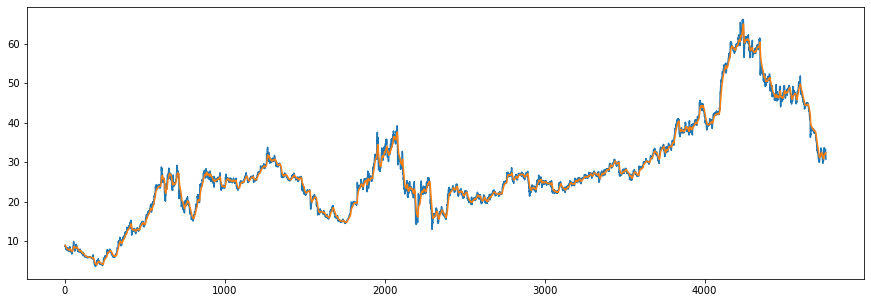

In [49]:
seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/FDP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_20 = []
sequential = []
count = 0

for i in df.values:
    if count == 19:
        data_20.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_arr = min_max_scaler.fit_transform(data_20)
        sequential.append(data_20_arr)
        data_20 = data_20[1:20]
    else:
        data_20.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 20, 4)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('FDP')]
    y = nr_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('FDP'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('FDP')]
    y = r_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.30635838150289, 1: 7.181818181818182, 2: 0.36712169619517865}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2896 - accuracy: 0.5034 - mse: 0.4599 - weighted_accuracy: 0.3112 - weighted_mse: 0.5298 - val_loss: 0.2989 - val_accuracy: 0.0464 - val_mse: 0.3560 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3560
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2119 - accuracy: 0.3871 - mse: 0.7657 - weighted_accuracy: 0.4246 - weighted_mse: 0.7762 - val_loss: 0.2894 - val_accuracy: 0.0464 - val_mse: 0.3841 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3841
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1931 - accuracy: 0.3004 - mse: 1.0058 - weighted_accuracy: 0.4766 - weighted_mse: 0.9841 - val_loss: 0.2787 - val_accuracy: 0.0464 - val_mse: 0.4226 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4226
Epoch 4/20
30/30 [==============================] - 0s 9m

7/7 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.5388 - mse: 1.1720 - weighted_accuracy: 0.5388 - weighted_mse: 1.1720


<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.171010360121727
Test accuracy: 0.5388127565383911


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 46
actual holds but predicted sell: 40
actual predicted holds: 113
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 88.97637795275591%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 56.25%
Percentage high sells correct: 52.27272727272727%
Percentage mid holds correct: 79.36507936507937%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bought: -28.741287068287125%
Share price: $0.43794212174263736
Shares owned at the moment: 0
Cash capital at the moment: $71.1894868926056

30/30 [==============================] - 0s 9ms/step - loss: 0.1333 - accuracy: 0.4942 - mse: 1.6331 - weighted_accuracy: 0.7416 - weighted_mse: 1.5349 - val_loss: 0.1878 - val_accuracy: 0.4241 - val_mse: 1.5662 - val_weighted_accuracy: 0.4241 - val_weighted_mse: 1.5662
Epoch 18/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1310 - accuracy: 0.5251 - mse: 1.6495 - weighted_accuracy: 0.7477 - weighted_mse: 1.5712 - val_loss: 0.1816 - val_accuracy: 0.4641 - val_mse: 1.7304 - val_weighted_accuracy: 0.4641 - val_weighted_mse: 1.7304
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1325 - accuracy: 0.4910 - mse: 1.6797 - weighted_accuracy: 0.7422 - weighted_mse: 1.5867 - val_loss: 0.1933 - val_accuracy: 0.4135 - val_mse: 1.7885 - val_weighted_accuracy: 0.4135 - val_weighted_mse: 1.7885
Epoch 20/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.5287 - mse: 1.6738 - weighted_accuracy: 0.7653 - weighted_mse: 1.5858

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 45
actual holds but predicted sell: 47
actual predicted holds: 107
Percentage buys correct: 4.25531914893617%
Percentage sells correct: 9.25925925925926%
Percentage holds correct: 90.67796610169492%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.06382978723404%
Percentage high sells correct: 48.148148148148145%
Percentage mid holds correct: 82.05128205128206%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bought: 0.2377433817825736%
Share price: $0.6160415787663689
Shares owned at the moment: 0
Cash capital at the moment: $99.9622556223461


Share price: $0.5656954891617805
Shares owned at the 

30/30 [==============================] - 0s 8ms/step - loss: 0.1140 - accuracy: 0.5823 - mse: 1.9548 - weighted_accuracy: 0.8195 - weighted_mse: 1.8802 - val_loss: 0.1593 - val_accuracy: 0.6192 - val_mse: 1.9579 - val_weighted_accuracy: 0.6192 - val_weighted_mse: 1.9579
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1134 - accuracy: 0.6086 - mse: 1.9525 - weighted_accuracy: 0.8183 - weighted_mse: 1.8904 - val_loss: 0.1879 - val_accuracy: 0.5105 - val_mse: 2.0037 - val_weighted_accuracy: 0.5105 - val_weighted_mse: 2.0037
Epoch 16/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1124 - accuracy: 0.6145 - mse: 1.9705 - weighted_accuracy: 0.8203 - weighted_mse: 1.9068 - val_loss: 0.1641 - val_accuracy: 0.6108 - val_mse: 2.0653 - val_weighted_accuracy: 0.6108 - val_weighted_mse: 2.0653
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1119 - accuracy: 0.5899 - mse: 1.9888 - weighted_accuracy: 0.8240 - weighted_mse: 1.9015

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1081 - accuracy: 0.6224 - mse: 2.0840 - weighted_accuracy: 0.8305 - weighted_mse: 2.0084 - val_loss: 0.1816 - val_accuracy: 0.5338 - val_mse: 2.3002 - val_weighted_accuracy: 0.5338 - val_weighted_mse: 2.3002
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1076 - accuracy: 0.6429 - mse: 2.1304 - weighted_accuracy: 0.8306 - weighted_mse: 2.0723 - val_loss: 0.1855 - val_accuracy: 0.5200 - val_mse: 2.3370 - val_weighted_accuracy: 0.5200 - val_weighted_mse: 2.3370
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.6171 - mse: 2.1576 - weighted_accuracy: 0.8231 - weighted_mse: 2.0923 - val_loss: 0.1725 - val_accuracy: 0.5738 - val_mse: 2.2704 - val_weighted_accuracy: 0.5738 - val_weighted_mse: 2.2704
Epoch 4/20
30/30 [==============================] - 0s 7ms/step - loss: 0.1061 - accuracy: 0.6345 - mse: 2.1584 - weighted_accuracy: 0.8294 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1668 - accuracy: 0.5890 - mse: 2.4467 - weighted_accuracy: 0.5890 - weighted_mse: 2.4467
Test loss: 0.16684797406196594
Test accuracy: 0.5890411138534546




<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 49
actual holds but predicted sell: 27
actual predicted holds: 123
Percentage buys correct: 5.769230769230769%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 90.44117647058823%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 55.76923076923077%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 83.70370370370371%


Capital: 100
Share price: $0.543669029946819
Shares owned at the moment: 183
Cash capital at the moment: $0.23496608041138245


Price increase from previously bought: 13.001123224306488%
Share price: $0.6160415787663689
Shares owned at the moment: 0
Cash capital at the moment: $112.66055207014271


Share price: $0.2378162055039441
Shares owned at th

30/30 [==============================] - 0s 8ms/step - loss: 0.0783 - accuracy: 0.7608 - mse: 3.1094 - weighted_accuracy: 0.8994 - weighted_mse: 3.0481 - val_loss: 0.1707 - val_accuracy: 0.6530 - val_mse: 3.2362 - val_weighted_accuracy: 0.6530 - val_weighted_mse: 3.2362
Epoch 17/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0780 - accuracy: 0.7500 - mse: 3.1126 - weighted_accuracy: 0.8991 - weighted_mse: 3.0171 - val_loss: 0.1864 - val_accuracy: 0.6203 - val_mse: 3.2754 - val_weighted_accuracy: 0.6203 - val_weighted_mse: 3.2754
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0787 - accuracy: 0.7571 - mse: 3.2099 - weighted_accuracy: 0.8854 - weighted_mse: 3.1559 - val_loss: 0.1896 - val_accuracy: 0.6266 - val_mse: 3.6960 - val_weighted_accuracy: 0.6266 - val_weighted_mse: 3.6960
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0792 - accuracy: 0.7479 - mse: 3.2091 - weighted_accuracy: 0.8874 - weighted_mse: 3.1235

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 47
actual holds but predicted sell: 22
actual predicted holds: 130
Percentage buys correct: 6.0%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.0%
Percentage high sells correct: 46.15384615384615%
Percentage mid holds correct: 84.50704225352112%


Capital: 100
Share price: $0.543669029946819
Shares owned at the moment: 183
Cash capital at the moment: $0.23496608041138245


Price increase from previously bought: -19.66783838965179%
Share price: $0.43794212174263736
Shares owned at the moment: 0
Cash capital at the moment: $80.15797998654703


Share price: $0.2378162055039441
Shares owned at the moment: 336
Cash capital

30/30 [==============================] - 0s 9ms/step - loss: 0.0647 - accuracy: 0.8112 - mse: 3.9127 - weighted_accuracy: 0.9198 - weighted_mse: 3.7830 - val_loss: 0.1771 - val_accuracy: 0.6951 - val_mse: 4.0752 - val_weighted_accuracy: 0.6951 - val_weighted_mse: 4.0752
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0657 - accuracy: 0.7998 - mse: 3.9262 - weighted_accuracy: 0.9156 - weighted_mse: 3.7583 - val_loss: 0.2024 - val_accuracy: 0.6530 - val_mse: 4.1624 - val_weighted_accuracy: 0.6530 - val_weighted_mse: 4.1624
Epoch 18/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0662 - accuracy: 0.8088 - mse: 4.0577 - weighted_accuracy: 0.9153 - weighted_mse: 3.9240 - val_loss: 0.1993 - val_accuracy: 0.6698 - val_mse: 4.8207 - val_weighted_accuracy: 0.6698 - val_weighted_mse: 4.8207
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.7940 - mse: 4.0393 - weighted_accuracy: 0.9080 - weighted_mse: 3.8775

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.8080 - mse: 4.0943 - weighted_accuracy: 0.9223 - weighted_mse: 3.9335 - val_loss: 0.2044 - val_accuracy: 0.6498 - val_mse: 4.6833 - val_weighted_accuracy: 0.6498 - val_weighted_mse: 4.6833
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0634 - accuracy: 0.8215 - mse: 4.1556 - weighted_accuracy: 0.9236 - weighted_mse: 3.9441 - val_loss: 0.2030 - val_accuracy: 0.6319 - val_mse: 4.2373 - val_weighted_accuracy: 0.6319 - val_weighted_mse: 4.2373
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0606 - accuracy: 0.8167 - mse: 4.2079 - weighted_accuracy: 0.9255 - weighted_mse: 4.0360 - val_loss: 0.1906 - val_accuracy: 0.6920 - val_mse: 4.5391 - val_weighted_accuracy: 0.6920 - val_weighted_mse: 4.5391
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0631 - accuracy: 0.8149 - mse: 4.2807 - weighted_accuracy: 0.9284 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.7215 - mse: 5.1168 - weighted_accuracy: 0.7215 - weighted_mse: 5.1168
Test loss: 0.1669837385416031
Test accuracy: 0.7214611768722534


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 30
actual holds but predicted sell: 15
actual predicted holds: 154
Percentage buys correct: 6.25%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 91.12426035502959%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 53.125%
Percentage high sells correct: 38.888888888888886%
Percentage mid holds correct: 84.52380952380952%


Capital: 100
Share price: $0.42787290382171994
Shares owned at the moment: 233
Cash capital at the moment: $0.03145384641547366


Price increase from previou

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 9ms/step - loss: 0.0522 - accuracy: 0.8457 - mse: 5.1086 - weighted_accuracy: 0.9379 - weighted_mse: 4.7897 - val_loss: 0.2236 - val_accuracy: 0.6487 - val_mse: 5.5981 - val_weighted_accuracy: 0.6487 - val_weighted_mse: 5.5981
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.8534 - mse: 5.2094 - weighted_accuracy: 0.9371 - weighted_mse: 4.8255 - val_loss: 0.2122 - val_accuracy: 0.6741 - val_mse: 5.3693 - val_weighted_accuracy: 0.6741 - val_weighted_mse: 5.3693
Epoch 3/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.8470 - mse: 5.2454 - weighted_accuracy: 0.9384 - weighted_mse: 4.9192 - val_loss: 0.2084 - val_accuracy: 0.7152 - val_mse: 5.6466 - val_weighted_accuracy: 0.7152 - val_weighted_mse: 5.6466
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0521 - accuracy: 0.8507 - mse: 5.3479 - weighted_accuracy: 0.9434 - weighted_mse: 4.9138 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.1748 - accuracy: 0.7352 - mse: 6.5380 - weighted_accuracy: 0.7352 - weighted_mse: 6.5380
Test loss: 0.17480702698230743
Test accuracy: 0.7351598143577576




<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 28
actual holds but predicted sell: 13
actual predicted holds: 158
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.80459770114942%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 26.666666666666668%
Percentage mid holds correct: 84.97109826589596%


Capital: 100
Share price: $0.42787290382171994
Shares owned at the moment: 233
Cash capital at the moment: $0.03145384641547366


Price increase from previously bought: 2.0726201312028403%
Share price: $0.43794212174263736
Shares owned at the moment: 0
Cash capital at the moment: $101.79135679794338


Share price: $0.3970359089345914
Shares owned

30/30 [==============================] - 0s 8ms/step - loss: 0.0392 - accuracy: 0.8916 - mse: 7.5900 - weighted_accuracy: 0.9548 - weighted_mse: 6.7824 - val_loss: 0.2600 - val_accuracy: 0.7300 - val_mse: 8.7452 - val_weighted_accuracy: 0.7300 - val_weighted_mse: 8.7452
Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0408 - accuracy: 0.8850 - mse: 7.5759 - weighted_accuracy: 0.9505 - weighted_mse: 6.7928 - val_loss: 0.2300 - val_accuracy: 0.7437 - val_mse: 8.4267 - val_weighted_accuracy: 0.7437 - val_weighted_mse: 8.4267
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.8929 - mse: 7.6826 - weighted_accuracy: 0.9553 - weighted_mse: 6.8170 - val_loss: 0.2360 - val_accuracy: 0.7500 - val_mse: 8.3318 - val_weighted_accuracy: 0.7500 - val_weighted_mse: 8.3318
Validation loss: 0.23601453006267548
Validation accuracy: 0.75


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2295 - accuracy:

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

30/30 [==============================] - 0s 8ms/step - loss: 0.0365 - accuracy: 0.8966 - mse: 7.7452 - weighted_accuracy: 0.9585 - weighted_mse: 6.8993 - val_loss: 0.2672 - val_accuracy: 0.6888 - val_mse: 8.0403 - val_weighted_accuracy: 0.6888 - val_weighted_mse: 8.0403
Epoch 2/20
30/30 [==============================] - 0s 7ms/step - loss: 0.0371 - accuracy: 0.9011 - mse: 7.8951 - weighted_accuracy: 0.9637 - weighted_mse: 6.9420 - val_loss: 0.2410 - val_accuracy: 0.7278 - val_mse: 8.3586 - val_weighted_accuracy: 0.7278 - val_weighted_mse: 8.3586
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0352 - accuracy: 0.8958 - mse: 7.9139 - weighted_accuracy: 0.9582 - weighted_mse: 7.0387 - val_loss: 0.2497 - val_accuracy: 0.7743 - val_mse: 9.2194 - val_weighted_accuracy: 0.7743 - val_weighted_mse: 9.2194
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0374 - accuracy: 0.8908 - mse: 8.0062 - weighted_accuracy: 0.9563 - weighted_mse: 7.0089 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 0.7671 - mse: 9.2304 - weighted_accuracy: 0.7671 - weighted_mse: 9.2304
Test loss: 0.20350639522075653
Test accuracy: 0.767123281955719


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 22
actual holds but predicted sell: 12
actual predicted holds: 165
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.16022099447514%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.166666666666664%
Percentage high sells correct: 28.571428571428573%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.42787290382171994
Shares owned at the moment: 233
Cash capital at the moment: $0.03145384641547366


Price increase 

<ipython-input-54-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

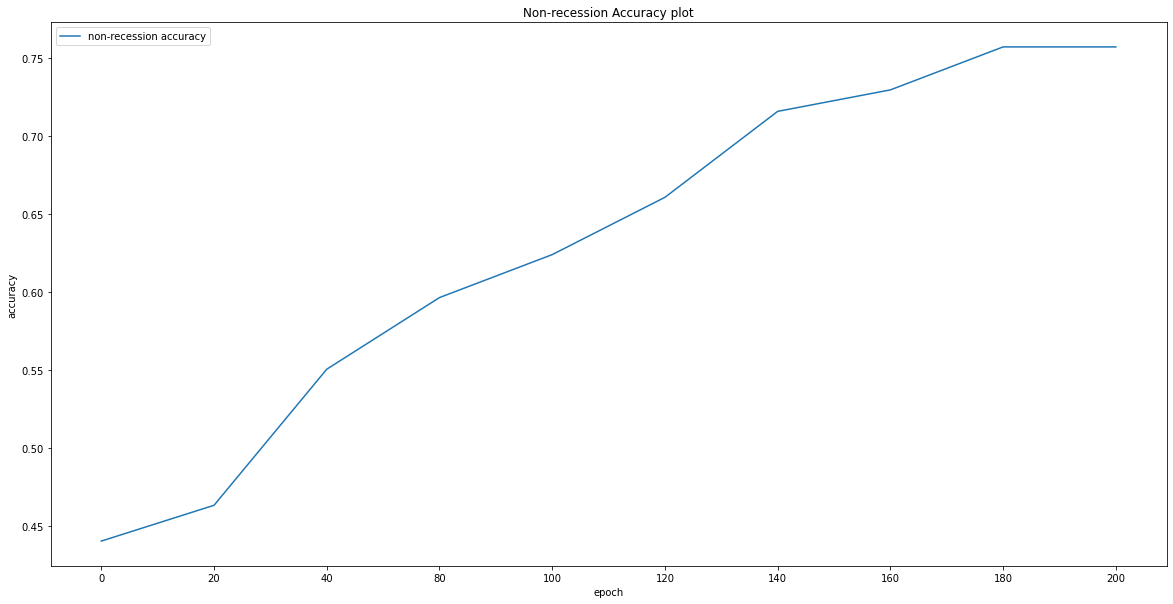

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

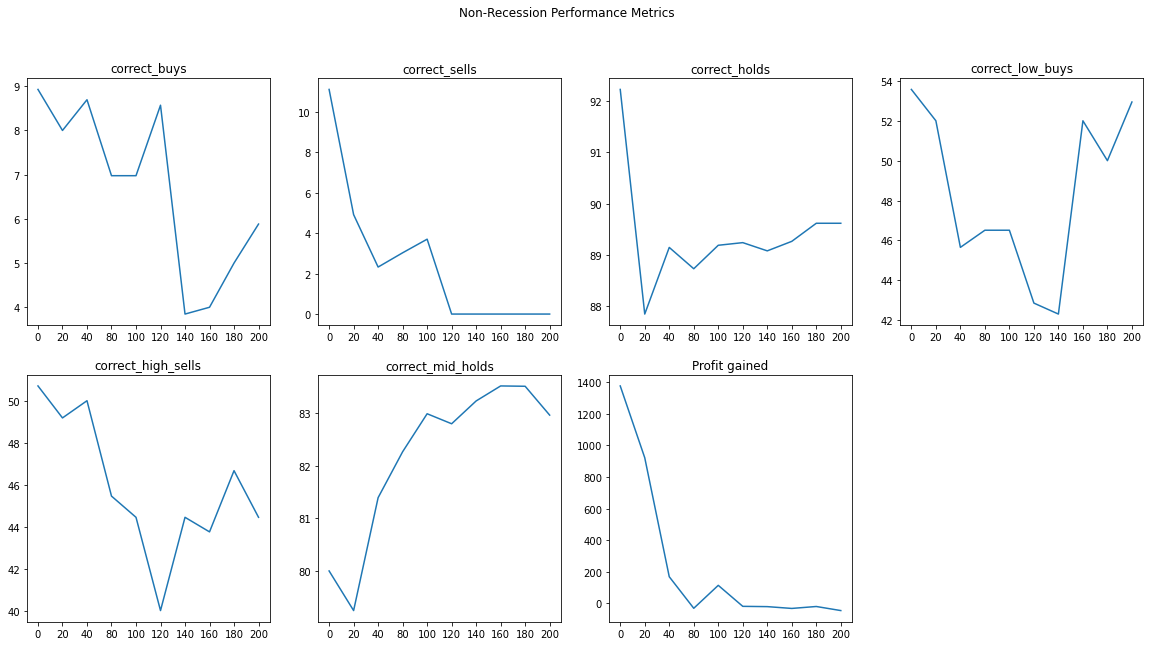

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

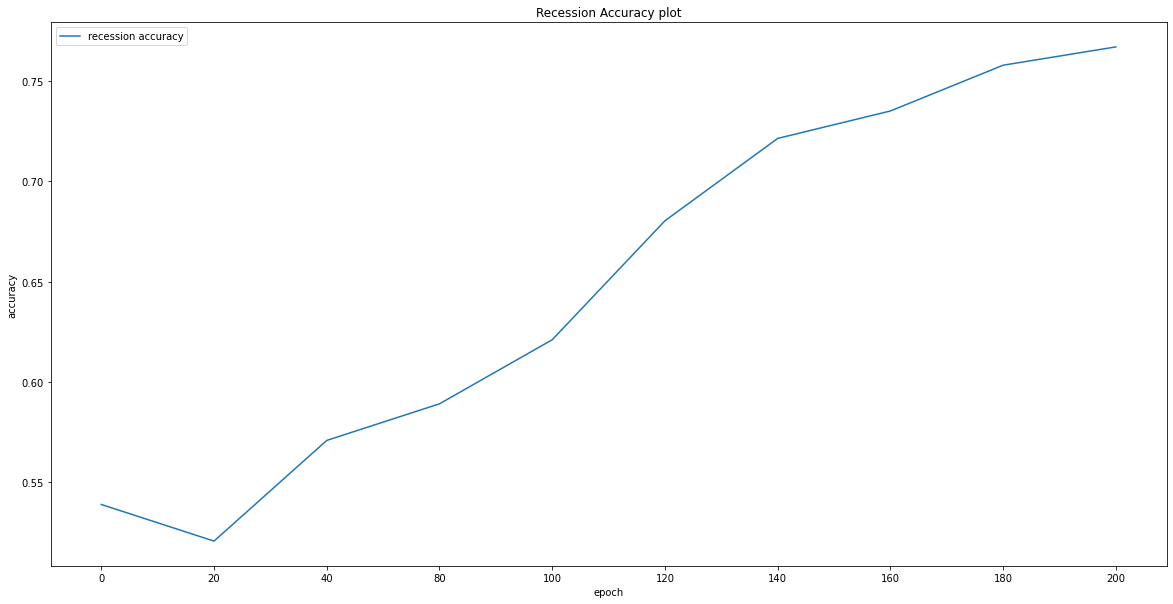

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

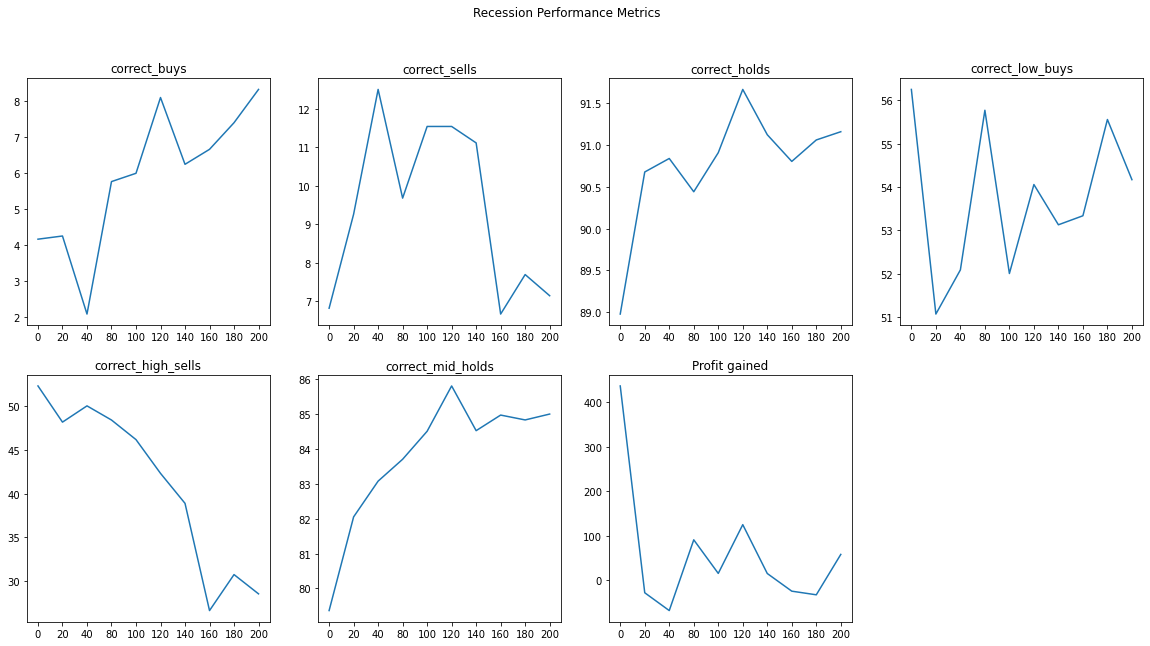

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")